In [2]:
# UNCOMMENT IF USING COLAB VM
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "CS589/H4"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs682/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/My Drive/CS589/H4


In [3]:
from utils import *
from cross_validation import *
import numpy as np
from nn import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
class Binarizer:
  def __init__(self,y):
    self.classes = np.unique(y)
    self.keys = dict(map(reversed, enumerate(self.classes) ))
    self.rev_keys = dict(map(reversed, self.keys.items() ))
    
  def transform(self,y):
    N = y.shape[0]
    y = y.astype(int)
    y_transformed = np.asarray(list(map(lambda x : self.keys[x],y)))
    num_classes = self.classes.shape[0]
    res = np.zeros((N,num_classes))
    res[np.arange(N),y_transformed] = 1
    return res

  def inv(self,y):
    return  np.asarray(list(map(lambda x : self.rev_keys[x],y)))

In [5]:
def loss_plot_helper(clf,X_train,y_train,X_test,y_test,k,f,reg,lr,epochs,train_bin):
  mean = np.mean(X_train,axis=0)
  std = np.std(X_train,axis=0)

  mean[f] = 0
  std[f] = 1 
    
  X_train = (X_train - mean[None,:])/std[None,:]


  y_train = train_bin.transform(y_train)
  y_test = train_bin.transform(y_test)

  losses_train = clf.sgd(X_train,y_train,reg,lr,epochs)

  losses_test = clf.loss(X_test,y_test,reg)[1]

  return losses_test

In [6]:
def loss_plot(clf,X,y,k,f,reg=0.25,lr=1e-3,epochs=10):
  
  l = X.shape[0]
  per = np.random.randint(l,size = l)
  shuffled_X,shuffled_y = X[per],y[per]
  split_ratio = 0.2
  point = int(split_ratio * l)

  X_train, y_train, X_test, y_test = shuffled_X[:point],shuffled_y[:point],shuffled_X[point:],shuffled_y[point:]
  train_bin = Binarizer(y_train)
  
  losses = []
  for i in range(2,X_train.shape[0]):
    loss = loss_plot_helper(clf,X_train[:i],y_train[:i],X_test,y_test,k,f,reg,lr,epochs,train_bin)
    losses.append(loss)

  plt.xlabel("Number of training instances (n)")
  plt.ylabel("Loss (J)")
  plt.plot(losses)
  plt.show()

In [7]:
def experiment(clf,X,y,k,f,reg=0.25,lr=1e-3,epochs=10):
  k_folds = CrossValidation(X,y,k)
  folds = k_folds.get_folds()
  train_accuracies = []
  train_f_1s = []
  test_accuracies = []
  test_f_1s = []
  for train,test in folds:
    X_train,y_train_o = train
    X_test,y_test = test

    mean = np.mean(X_train,axis=0)
    std = np.std(X_train,axis=0)

    mean[f] = 0
    std[f] = 1 
    
    X_train = (X_train - mean[None,:])/std[None,:]
    X_test = (X_test - mean[None,:])/std[None,:]

    train_bin = Binarizer(y_train_o)
    y_train = train_bin.transform(y_train_o)

    losses_epooch = clf.sgd(X_train,y_train,reg,lr,epochs)

    train_predict = clf.predict(X_train)
    test_predict = clf.predict(X_test)

    train_predict = train_bin.inv(train_predict)
    test_predict = train_bin.inv(test_predict)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(losses_epooch)
    plt.show()

    train_accuracies.append(k_folds.accuracy(train_predict,y_train_o))
    train_f_1s.append(k_folds.f1_score(train_predict,y_train_o))

    test_accuracies.append(k_folds.accuracy(test_predict,y_test))
    test_f_1s.append(k_folds.f1_score(test_predict,y_test))
  
  
  print("Average train accuracy ", np.average(train_accuracies))
  print("Average test accuracy ", np.average(test_accuracies))
  
  print("Average train f-1 ", np.average(train_f_1s))
  print("Average test f-1 ", np.average(test_f_1s))

In [8]:
# X = np.ones((10,3))
# y = np.ones((10,))
# X = np.random.randint(0,10,(1000,3))
# y = np.random.randint(0,3,(1000,))

In [9]:
X,y,f = load("house_votes")

In [10]:
input_size = X.shape[1]
output_size = np.unique(y).shape[0]

In [29]:
classifier = NeuralNetwork(input_size,[10,10,10,10],output_size)

In [30]:
reg = 0
lr = 5e-2
epochs = 100
k_folds = 8

In [ ]:
experiment(classifier,X,y,k_folds,f,reg = reg, lr=lr, epochs = epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


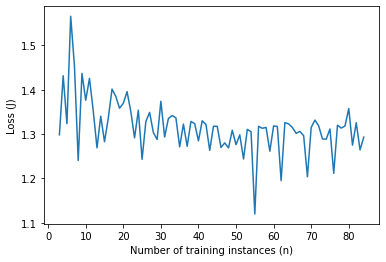

In [31]:
loss_plot(classifier,X,y,k_folds,f,reg = reg, lr=lr, epochs = epochs)